In [1]:
import numpy as np
import random
import os
import cv2
from matplotlib import pyplot as plt
from numba import jit,cuda
import tensorflow as tf
from time import time
import pickle as pkl
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten,MaxPooling2D
from keras.layers import BatchNormalization
from keras.models import Sequential
from skimage.io import imsave


In [2]:
"""
%%cmd
pip install wandb
pip install scikit-image
pip install skimage
pip install numba
pip install keras-unet

"""

'\n%%cmd\npip install wandb\npip install scikit-image\npip install skimage\npip install numba\npip install keras-unet\n\n'

In [3]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5



In [4]:
train_images_list =os.listdir("data/train/")
test_images_list = os.listdir("data/test/")

random.shuffle(train_images_list)
random.shuffle(test_images_list)

random.shuffle(train_images_list)
random.shuffle(test_images_list)

random.shuffle(train_images_list)
random.shuffle(test_images_list)

In [5]:
trainImageColorful = list(map(lambda x : "data/train/"+x ,train_images_list[0:1000]))
testImageColorful = list(map(lambda x : "data/test/"+x ,test_images_list[0:100]))


In [6]:
len(trainImageColorful)

1000

In [7]:
def preprocess_image_to_gray_lab(img):
    img = cv2.resize(cv2.imread(img),(400,400))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #img = img_to_array(load_img(img))
    img = rgb2lab(img/255)
    img = img[:,:,0]
    img = img.reshape(400, 400, 1)
    
    return img

def preprocess_image_to_lab(img):
    img = cv2.resize(cv2.imread(img),(400,400))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #img = img_to_array(load_img(img))
    img = rgb2lab(img/255)
    img = img[:,:,1:]
    img /= 128
    img = img.reshape(400, 400, 2)

    return img



In [8]:
trainImageColorful[0]

'data/train/insta29918.jpg'

In [9]:

def train_data_generator(trainImageColorful,num_photos_per_batch):
    
    X, y = [], []

    n = 0

    while True:

        for key in trainImageColorful:
            n +=1

         

          
          
                
            X.append(preprocess_image_to_gray_lab(key))
                   
            y.append(preprocess_image_to_lab(key))
         

            if n==num_photos_per_batch:
                u = np.array(X)
                w = np.array(y)
            
             
               
                yield(u,w)
                
                X,  y = [], []
                n = 0
def valid_data_generator(validImageColorful,num_photos_per_batch):
    
    X, y = [], []

    n = 0

    while True:

        for key in validImageColorful:
            n +=1

      
          
          
                
            X.append(preprocess_image_to_gray_lab(key))
                   
            y.append(preprocess_image_to_lab(key))
         

            if n==num_photos_per_batch:
                u = np.array(X)
                w = np.array(y)
            
             
               
                yield(u,w)
                
                X,  y = [], []
                n = 0
 

In [10]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
#import wandb 
#wandb.init()

In [12]:
model = Sequential()
model.add(InputLayer(input_shape=(400, 400, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same' , strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same' , strides=2))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same' ))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))

In [13]:
from tensorflow.keras.optimizers import Adam

model.compile(Adam(learning_rate=0.1),loss='mse' ,metrics=["accuracy"])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 200, 200, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 100, 128)     73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 128)       1

In [14]:
epochs = 100
number_pics_per_bath = 10
train_steps = len(trainImageColorful)//number_pics_per_bath
valid_steps = len(testImageColorful)//number_pics_per_bath

In [15]:
from keras.models import Model,load_model
model = load_model("model_weights\saved-model-05-0.69.hdf5")

In [16]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)
filepath = "model_weights/saved-model-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [20]:
train_generator = train_data_generator(trainImageColorful=trainImageColorful,num_photos_per_batch=number_pics_per_bath)
valid_generator = valid_data_generator(validImageColorful=testImageColorful,num_photos_per_batch=number_pics_per_bath)
 
model.fit(train_generator,epochs=epochs,steps_per_epoch=train_steps,validation_data=(valid_generator),validation_steps=valid_steps,workers=-1,verbose=1,callbacks=[es,checkpoint])
       

Epoch 1/100
100/100 [==============================] - 492s 5s/step - loss: 0.0104 - accuracy: 0.6574 - val_loss: 0.0119 - val_accuracy: 0.6313

Epoch 00001: val_accuracy improved from -inf to 0.63126, saving model to model_weights\saved-model-01-0.63.hdf5
Epoch 2/100
100/100 [==============================] - 422s 4s/step - loss: 0.0094 - accuracy: 0.6631 - val_loss: 0.0120 - val_accuracy: 0.6395

Epoch 00002: val_accuracy improved from 0.63126 to 0.63955, saving model to model_weights\saved-model-02-0.64.hdf5
Epoch 3/100
100/100 [==============================] - 432s 4s/step - loss: 0.0086 - accuracy: 0.6653 - val_loss: 0.0120 - val_accuracy: 0.6522

Epoch 00003: val_accuracy improved from 0.63955 to 0.65219, saving model to model_weights\saved-model-03-0.65.hdf5
Epoch 4/100
100/100 [==============================] - 441s 4s/step - loss: 0.0079 - accuracy: 0.6684 - val_loss: 0.0123 - val_accuracy: 0.6465

Epoch 00004: val_accuracy did not improve from 0.65219
Epoch 5/100
100/100 [==

In [21]:
def show_images(i,coloring):
    fig = plt.figure(figsize=(10, 7))
    rows = 1
    columns = 2
    fig.add_subplot(rows, columns, 1)
  
    normal = load_img(i,color_mode="grayscale",target_size=(400,400))
    plt.imshow(normal, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.title("Gray image")
    

    fig.add_subplot(rows, columns, 2)
    
  
    plt.imshow(coloring)
    plt.axis('off')
    plt.title("AI Colorizing")

def mergeOutput(x,output):
    output *= 128
  
    cur = np.zeros((400, 400, 3))
    cur[:,:,0] = x[0][:,:,0]
    cur[:,:,1:] = output[0]
    return cur

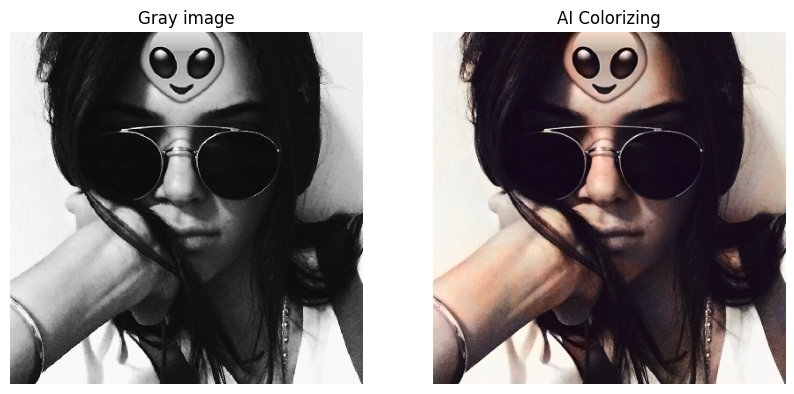

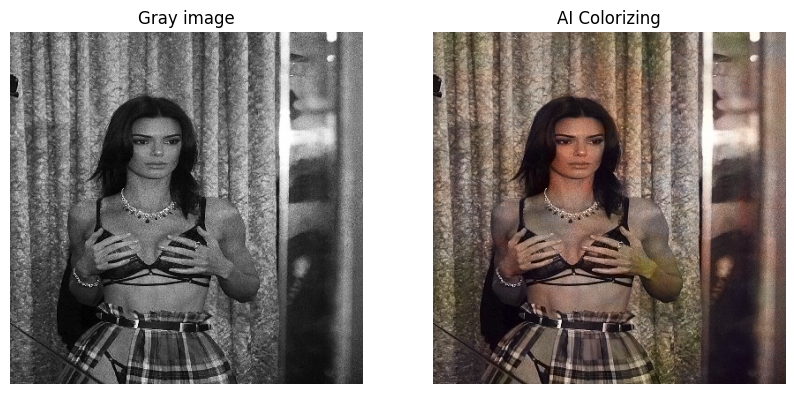

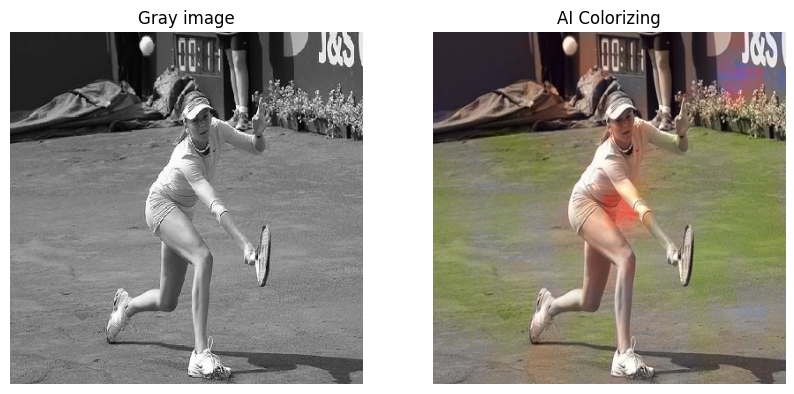

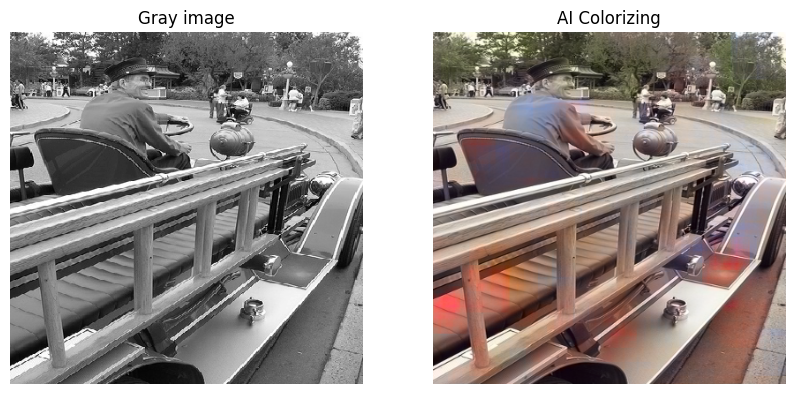

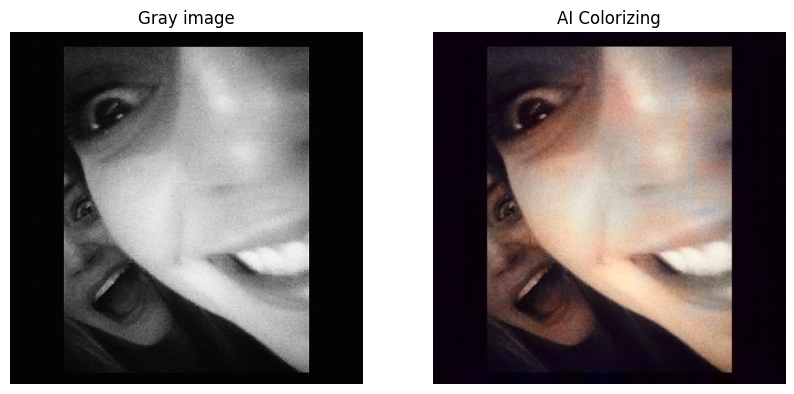

In [22]:
for i in testImageColorful[0:5]:
    
    x = preprocess_image_to_gray_lab(i)
    
    x = x.reshape(1,400,400,1)

    output = model.predict(x)
    
    cur = mergeOutput(x,output)
    
    img = lab2rgb(cur)

   
    show_images(i,img)

   
 

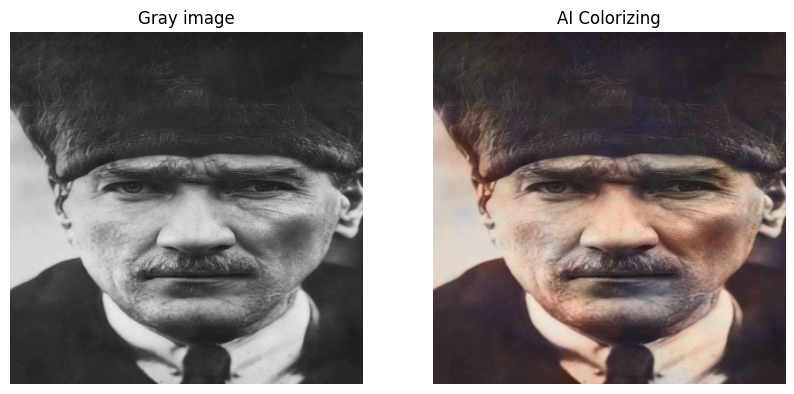

In [23]:
x = preprocess_image_to_gray_lab("test images/ataturk3.jpg")

x = x.reshape(1,400,400,1)

output = model.predict(x)
    
cur = mergeOutput(x,output)
    
img = lab2rgb(cur)

   
show_images("test images/ataturk3.jpg",img)
